# Linear Regression
### EK 10/26

Using all features to predict attention with linear regression.

### Imports

In [209]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from warnings import filterwarnings
filterwarnings('ignore')



### Read in data

In [210]:
games = pd.read_csv("/Users/elisabethkollrack/Thesis/EK-thesis/game_attention.csv")
# adjust attention
# take log of attention
games['log_attention'] = np.log1p(games['attention'])

### Adjust game time to minutes and date to datetime format

In [211]:
games['date'] = pd.to_datetime(games['date'])
games['gametime'] = games['gametime'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

### Encode categorical features

In [212]:
categorical_cols = ['weekday', 'home_team', 'away_team']
games_encoded = pd.get_dummies(games, columns=categorical_cols, drop_first=True)


### Visualize numeric features

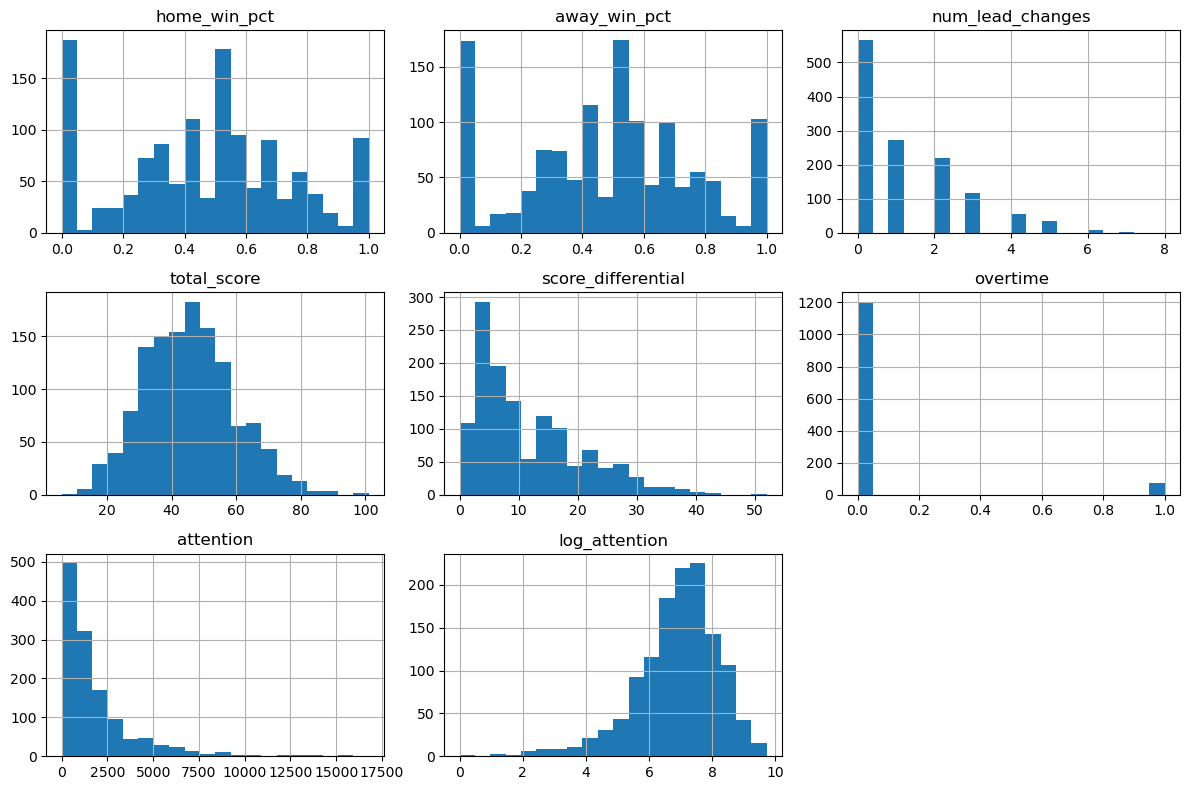

In [213]:

numeric_cols = ['home_win_pct','away_win_pct','num_lead_changes','total_score','score_differential','overtime','attention', 'log_attention']
games[numeric_cols].hist(figsize=(12,8), bins=20)
plt.show()

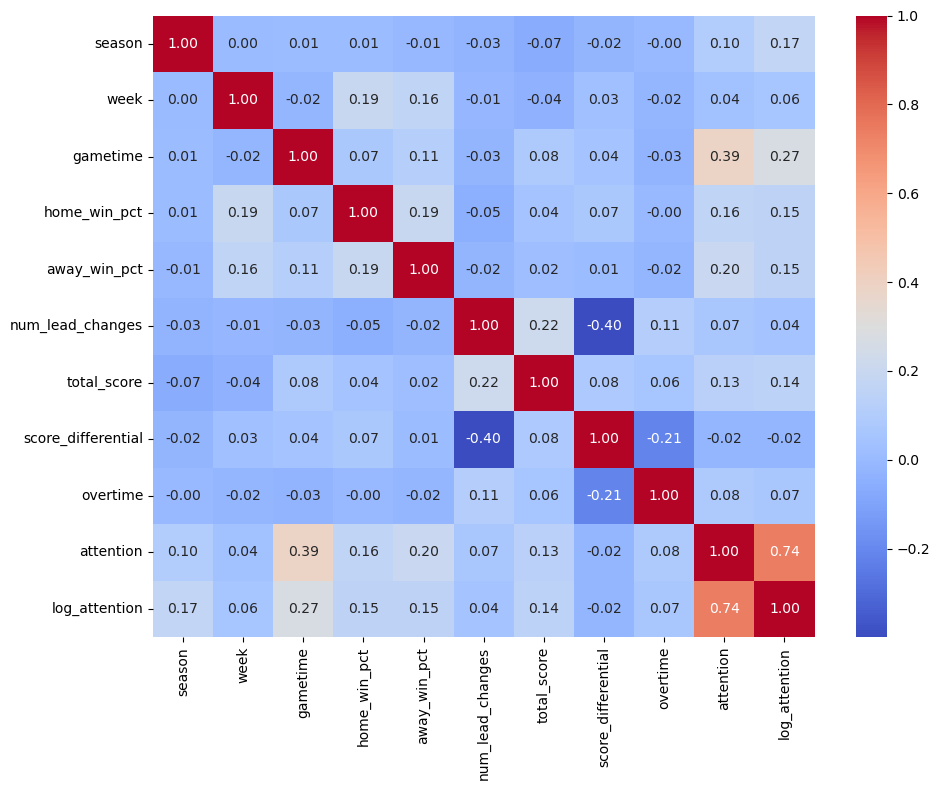

In [214]:
plt.figure(figsize=(10,8))
sns.heatmap(games_encoded.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


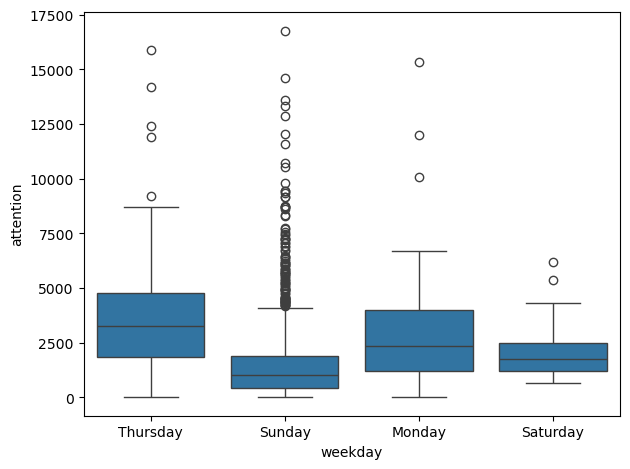

In [215]:
sns.boxplot(x='weekday', y='attention', data=games)
plt.show()


In [216]:
X = games_encoded.select_dtypes(include='number').drop(columns=['attention'])
vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values(by='VIF', ascending=False)


,feature,VIF
0,season,53.751094
9,log_attention,32.139682
2,gametime,30.266576
6,total_score,13.071168
1,week,4.549018
4,away_win_pct,4.144118
3,home_win_pct,3.989730
7,score_differential,3.376439
5,num_lead_changes,2.198971
8,overtime,1.126284


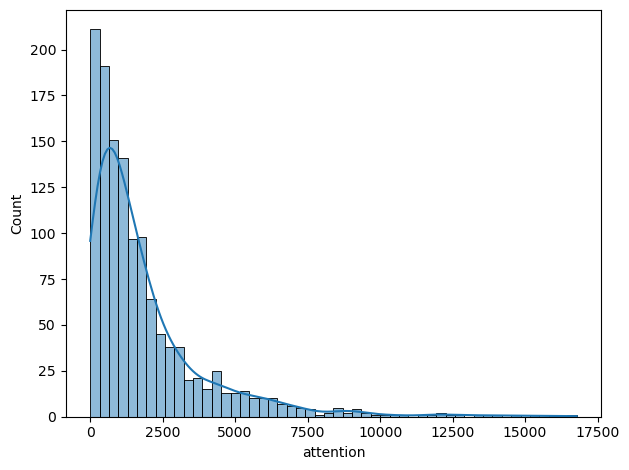

In [217]:
sns.histplot(games['attention'], kde=True)
plt.show()


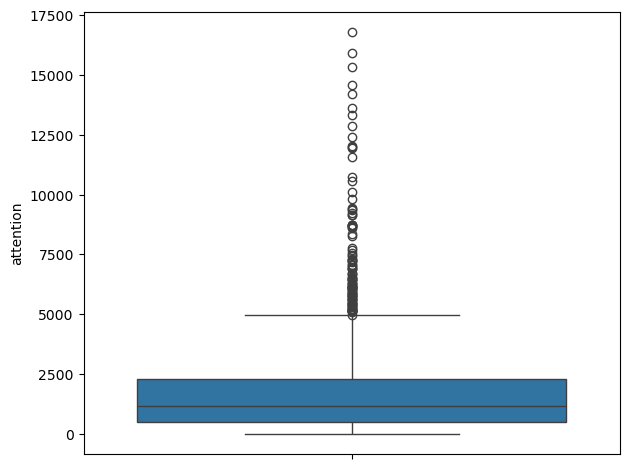

In [218]:
sns.boxplot(y='attention', data=games)
plt.show()


In [219]:
# Drop irrelevant columns

X = games_encoded.drop(columns=['attention','log_attention', 'game_id', 'date'])  # only numeric/coded features
y = games_encoded['log_attention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 0.8150170894730049
R^2: 0.6242791569256536


In [220]:
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_})
coefficients.sort_values(by='Coefficient', ascending=False)


,Feature,Coefficient
22,home_team_GB,4.353538
19,home_team_DAL,4.312458
31,home_team_NE,4.264818
39,home_team_SEA,4.226148
32,home_team_NO,3.888403
...,...,...
1,week,0.009088
6,total_score,0.007839
2,gametime,0.001040
7,score_differential,-0.001135


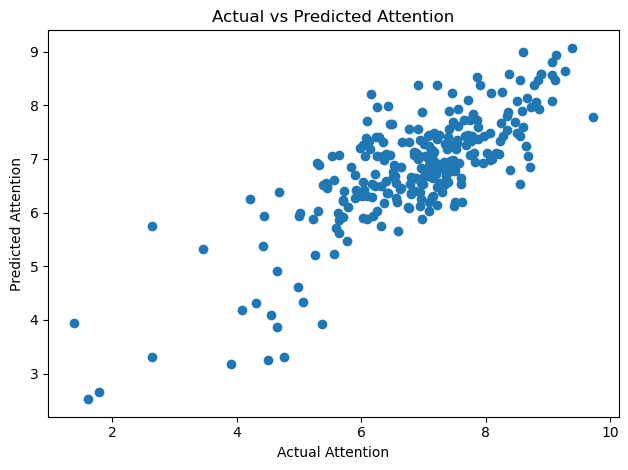

In [221]:


plt.scatter(y_test, y_pred)
plt.xlabel("Actual Attention")
plt.ylabel("Predicted Attention")
plt.title("Actual vs Predicted Attention")
plt.show()


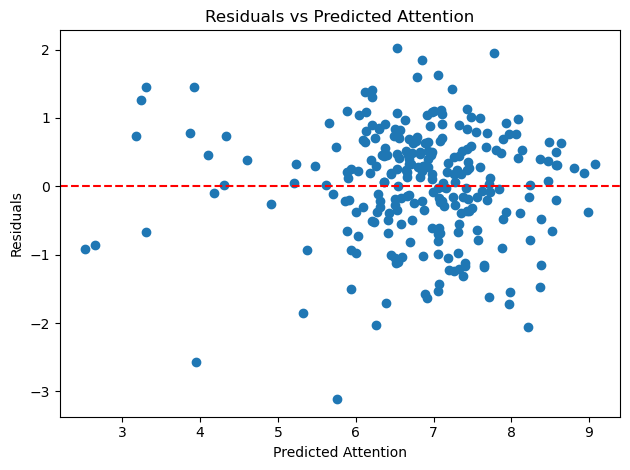

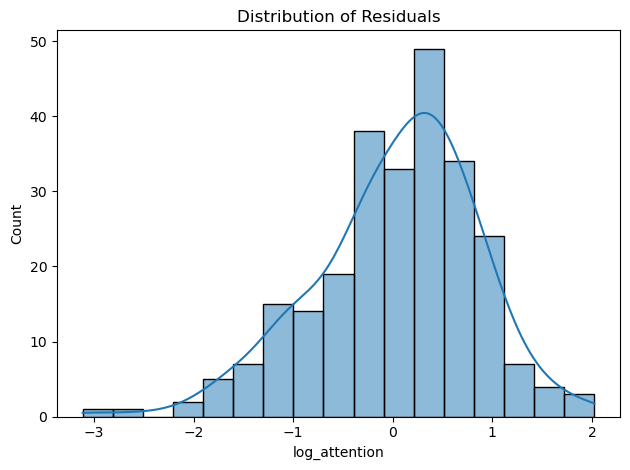

In [222]:
# Residual analysis 
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Attention")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Attention")
plt.show()
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()


### LR with Interaction Terms

In [223]:
# Define selective interaction terms
X['home_away_win_interaction'] = X['home_win_pct'] * X['away_win_pct']
X['lead_diff_interaction'] = X['num_lead_changes'] * X['score_differential']
X['total_score_leads_interaction'] = X['total_score'] * X['num_lead_changes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict & evaluate
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("With Selective Interaction Terms:")
print("RMSE:", rmse)
print("R^2:", r2)


With Selective Interaction Terms:
RMSE: 0.8206520088367303
R^2: 0.6190658293753892
